In [ ]:
# Load the files from the lab
from google.colab import files
uploaded = files.upload()

Saving Cancer_Xtest.npy to Cancer_Xtest.npy
Saving Cancer_Xtrain.npy to Cancer_Xtrain.npy
Saving Cancer_ytest.npy to Cancer_ytest.npy
Saving Cancer_ytrain.npy to Cancer_ytrain.npy


# Introdução

Neste trabalho, o objetivo é obter modelos que consigam generalizar o melhor possível em problemas de classificação e de regressão. Para obter a melhor performance sem obter overfitting nos resultados, o treino e a escolha dos hiperparâmetros é apenas feita utilizando o training data.

No primeiro problema, vamos explorar um classificador usando uma SVM (Support Vector Machine) e Naive Bayes, ajustando o hiperparâmetro C, que corresponde ao custo e analisando a “accuracy” obtida e a confusion matrix.
No segundo problema, vamos explorar uma rede neuronal MLP (Multi-Layered Perceptron) e também uma Regressão de Lasso e Ridge.


# 1. Problema de Classificação

Nesta seção vamos resolver um problema de classificação. Vamos tentar duas formas diferentes e avaliar as vantages e desvantagem de cada uma delas.
 Primeiro vamos importar as bibliotecas, fazer load dos dados e avalia-los.

In [342]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd

In [355]:
x_train = np.load("Cancer_Xtrain.npy")
y_train = np.load("Cancer_ytrain.npy")
x_test = np.load("Cancer_Xtest.npy")
y_test = np.load("Cancer_ytest.npy")

print(x_train.shape)
print(y_test.shape)

(92, 9)
(24, 1)





Ou seja o nosso dataset tem 9 features e queremos ser capazes de classifica-lo em duas classes, 1 (com cancro) ou 2 (sem cancro). A primeira ideia que nos vem a cabeça é partir do pressuposto que as features são independentes umas das outras e assim usar um Naive Bayes Classifier. 


## 1.1 Naive Bayes

Como vimos no ultimo laboratório os classificador de bayes atua da seguinte  forma:

$$
\hat{w} = \underset{w \in \Omega}{\operatorname{argmax}}  P(w|x)
$$

$$
p(x_1, \dots, x_p|w_k) \approx \prod_{i=1}^{p}p(x_i|w_k)
$$


Para implementá-lo vamos usar a função MultinomialNB do modulo *sklearn*, definimos o parâmetro alpha como zero para que não haja smoothing nos dados e *fit_prior = True*, para que o classificador não assuma que as probabilidades das duas classes são iguais.



In [351]:
clf_nb = MultinomialNB(alpha=0, fit_prior=True)
clf_nb.fit(x_train, y_train.reshape(-1,))
prb_nb = clf_nb.predict(x_test)
print("Naive Bayes Accuracy Score = {}".format(accuracy_score(y_test, prb_nb)))
print("Naive Bayes Accuracy Score = {}".format(recall_score(y_test, prb_nb)))
print("Confusion Matrix")
print(confusion_matrix(y_test, prb_nb))

Naive Bayes Accuracy Score = 0.75
Naive Bayes Accuracy Score = 0.6666666666666666
Confusion Matrix
[[ 6  3]
 [ 3 12]]


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Escolhemos como avaliadores de perfomance o accuracy score e o recall score. O primeira faz uma avaliação mais geral da classificação e mostra o quão preciso o nosso modelo é a prever as classes. O segundo faz a seguinte conta:

$$ 
\frac{t_p}{t_p+f_n}
$$
Onde $t_p$ é verdadeiro positivo e $f_n$ é falso negativo. Este avaliador é útil porque ataca um problema sério que surge neste problema em espcífico ja que, ao classificar cancro, queremos minimizar o número de falsos negativos (paciente com cancro que foram erroneamente classificados), ou seja o recall score deve estar o mais próximo de 1 possível.

Pelos resultados observados vemos que o Naive Bayes até tem uma precisão aceitável, mas tem muitos falsos negativos o que torna este classificador muito perigoso. Vamos tentar então outra abordagem.


##1.2 Suport Vector Machines
Com uma SVM pretende encontrar um plano no espaço das features que separe claramente os dados em duas categorias, é de notar que SVM’s também podem ser utilizadas em problemas de regressão. O objetivo é encontrar a decision boundary que tem maior margem em relação a support vector (que são os pontos dos dados que estão mais perto da decision boundary). Aqui também é importante, clarificar o conceito de hard margin e soft margin, que diferem entre si de forma muito resumida no facto de a soft margin ser mais flexível permitindo que pontos estejam do lado oposto da decision boundary, ou seja, na classe errada ao ter um custo (parâmetro C) inderior quando se comete um erro deste tipo. Neste problema, experimentámos valores para o parâmetro C, que quanto mais perto de zero, mais se aproxima de ser soft margin e quanto mais perto de 1 mais próximo de hard margin. Achamos que neste caso é importante utilizar hard margin, apesar de termos testado outros valores de C, porque as consequências de se obter falsos-negativos ou falsos-positivos são muito impactantes.

Para treinar este modelo vamos dividir o training set em dois e testar o resultado para diferentes valores de C e weight_classes.
Tal como explicado anteriormente, C controla a rigidez da margem e por isso exterimentámos vários valores.

Como estamos a tentar diminuir o recall faz sentido que a classe Com Cancro receba um peso maior que a clase Sem Cancro. Vamos ver como o programa se comporta:

In [356]:
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
#dividir training data
X_train = x_train[:75,].copy()
Y_train = y_train[:75,].copy()
X_test =  x_train[75:,].copy()
Y_test = y_train[75:,].copy()
C = [0.001, 0.01, 0.1, 1, 1.5, 2 ,5, 10, 20, 100]
weights = [0.2, 0.5, 0.75, 1]
df = pd.DataFrame(index = C, columns=weights)
df.index.name = " C"
#Fit and predict svm
for c in C:
    col = []
    for w in weights:
        clf_svm = svm.SVC(C=c, class_weight={1:1, 2:w})
        clf_svm =  clf_svm.fit(X_train, Y_train.reshape(-1,))
        prb_svm = clf_svm.predict(X_test)
       # print("c= {} w = {}, SVM Accuracy Score = {}".format(c, w, accuracy_score(Y_test, prb_svm)))
       # print("SVM Recall Score = {}".format(recall_score(Y_test, prb_svm, zero_division=0 )))
        col.append((round(accuracy_score(Y_test, prb_svm),3), round(recall_score(Y_test, prb_svm, zero_division=0 ), 2)))
    df.loc[c] = col
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
print("\t\t\t\tWeights")
df = df.round(2)
print(df)

				Weights
                 0.20           0.50           0.75           1.00
 C                                                                
0.00     (0.529, 1.0)   (0.529, 1.0)   (0.529, 1.0)   (0.471, 0.0)
0.01     (0.529, 1.0)   (0.529, 1.0)   (0.529, 1.0)   (0.471, 0.0)
0.10     (0.529, 1.0)   (0.529, 1.0)   (0.529, 1.0)   (0.471, 0.0)
1.00     (0.529, 1.0)   (0.824, 1.0)  (0.824, 0.89)  (0.824, 0.89)
1.50     (0.529, 1.0)   (0.824, 1.0)  (0.824, 0.89)  (0.824, 0.89)
2.00     (0.588, 1.0)  (0.824, 0.89)  (0.824, 0.89)  (0.765, 0.78)
5.00     (0.765, 1.0)  (0.824, 0.89)  (0.765, 0.78)  (0.765, 0.78)
10.00    (0.765, 1.0)  (0.824, 0.89)  (0.824, 0.89)  (0.824, 0.89)
20.00    (0.765, 1.0)  (0.824, 0.89)  (0.824, 0.89)  (0.824, 0.89)
100.00  (0.765, 0.78)  (0.647, 0.78)  (0.706, 0.78)  (0.706, 0.78)


Aalisando os resultados a configuração que sai melhor é c = 1.5 e weight = 0.5, que consegue obter um recall perfeito ao mesmo tempo que mantém um accuracy score aceitavel. Vamos ver como o modelo se comporta nos dados de teste.

In [357]:
x_test = scaler.transform(x_test)
clf_svm2 = svm.SVC(C=1.5, class_weight={1:1, 2:0.5})
clf_svm2 =  clf_svm2.fit(x_train, y_train.reshape(-1,))
prb_svm2 = clf_svm2.predict(x_test)
print("c= 1, SVM Accuracy Score = {}".format(accuracy_score(y_test, prb_svm2)))
print("SVM Recall Score = {}".format(recall_score(y_test, prb_svm2, zero_division=0 )))
print("Confusion Matrix")
print(confusion_matrix(y_test, prb_svm2))

c= 1, SVM Accuracy Score = 0.7916666666666666
SVM Recall Score = 1.0
Confusion Matrix
[[ 9  0]
 [ 5 10]]


Sacrificando um pouco da Accuracy score conseguimos obter um valor perfeito para o recall, este modelo, apesar de falhar algumas vezes produz menos falsos negativos e pode ser usado de forma mais segura.

O melhor resultado que se pode obter numa confusion matrix é ser uma matriz apenas com valores na diagonal principal, isto quer dizer que o modelo classifica corretamente todos os exemplos na classe a que pertencem, uma vez que cada entrada da matriz corresponde à probabilidade de dado exemplo ser classificado na classe y, correspondendo assim uma classe a uma coluna diferente. 
Assim, analisando ambas as confusion matrices , é de notar que o svm é mais interessante por diminuir os falsos positivos e ter mais elementos na diagonal

# 2. Regressão

Vamos agora tentar prever o preço de algum bem com métodos de regressão. Vamos começar por fazer load dos dados e analisa-los.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, max_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import  StandardScaler, scale
import matplotlib.pyplot as plt

In [ ]:
x_train = np.load("Real_Estate_Xtrain.npy")
y_train = np.load("Real_Estate_ytrain.npy")
x_test = np.load("Real_Estate_Xtest.npy")
y_test = np.load("Real_Estate_ytest.npy")

print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(102, 13)
(404,)
(102,)


Para começar vamos fazer uma regressão linear e ver como os parâmetros se comportam.

In [ ]:
#fit
X = np.append(np.ones((x_train.shape[0], 1)), x_train, axis = 1)
beta = np.linalg.solve(X.T@X, X.T@y_train)
#predict
X_test = np.append(np.ones((x_test.shape[0], 1)), x_test, axis = 1)
y_predict = X_test @ beta
print("Linear Regression Mean Squared Error = {}".format(mean_squared_error(y_predict, y_test)))
print("Linear Regression Max Error = {}".format(max_error(y_test, y_predict)))
#beta has many small parameters => lasso regression to do parameter selection
print(beta)

Linear Regression Mean Squared Error = 20.472070739655265
Linear Regression Max Error = 14.588849812747434
[42.831 -0.115 0.060 0.016 2.914 -20.164 3.139 0.008 -1.657 0.342 -0.013
 -0.927 0.008 -0.590]


<Figure size 720000x72000 with 0 Axes>

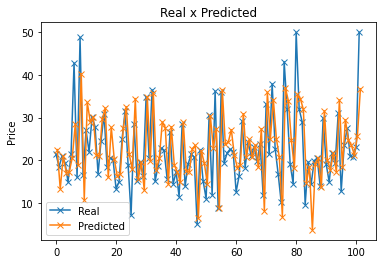

In [ ]:
plt.figure(figsize=(10000, 1000))
x = np.arange(y_test.size)
fig, ax = plt.subplots()
plt.plot(x , y_test, 'x-', label='Real')
plt.plot(x + width, y_predict, 'x-', label='Predicted')
ax.set_ylabel('Price')
ax.set_title('Real x Predicted')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()
plt.show()

Sabemos que as regressões lineares tendem a fazer um "overfitting" do modelo aos dados de treino, de forma a contornar esse problema é costume adicionar um termo regularizador $\alpha$ que puxa os coeficientes para zero e torna-os mais adequados para novos datasets.

As regressões que atuam dessa forma são a *Ridge* e a *Lasso*, sendo que a ultima consegue fazer com que as *features* menos relevantes não contribuam em nada para a previsão. 

Para fazer uma *Lasso Regression* é importante normalizar os dados antes, para isso vamos usar o *StandardScaler* do modulo *sklearn*

In [ ]:
scaler = StandardScaler()
Xs_train=scaler.fit_transform(x_train)
#y_train = scaler.fit_transform(y_train.reshape(-1,1))
#y_test = scaler.fit_transform(y_test.reshape(-1,1))
Xs_test = scaler.transform(x_test)

lasso = Lasso(alpha = 0.1)
lasso.fit(Xs_train, y_train.reshape(-1,))
y_pred3 = lasso.predict(Xs_test)
print("Lasso Regression Mean Squared Error = {}".format(mean_squared_error(y_pred3, y_test)))
print("Lasso Regression Max Error = {}".format(max_error(y_test, y_pred3)))
print(lasso.coef_)

Lasso Regression Mean Squared Error = 19.402350579960178
Lasso Regression Max Error = 14.945289923374013
[-0.733 1.025 -0.039 0.765 -1.798 2.420 0.000 -2.929 1.613 -1.008 -1.850
 0.678 -4.149]


<Figure size 720000x72000 with 0 Axes>

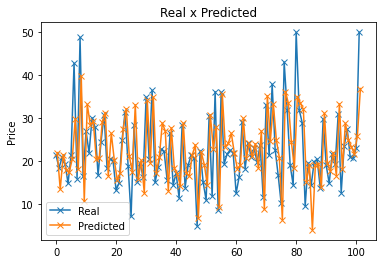

In [ ]:
plt.figure(figsize=(10000, 1000))
x = np.arange(y_test.size)
fig, ax = plt.subplots()
plt.plot(x , y_test, 'x-', label='Real')
plt.plot(x + width, y_pred3, 'x-', label='Predicted')
ax.set_ylabel('Price')
ax.set_title('Real x Predicted')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()
plt.show()

Vimos que apesar de tudo as duas regressões atuam de forma muito parecida, mas a *Lasso*, como previsto, saiu-se melhor.

## 2.2 Neural Network

Por fim vamos tentar encontrar a solução usando uma rede neuronal, 

Para encontrar a melhor configuração fomos alterando o número de neurónios por cada camada e também variando o número de camadas. Tal como esperado e abordado nas aulas teóricas obtêm-se se melhores resultados usando um maior número de camadas, uma vez que a rede consegue criar mais funções não lineares com um menor número de unidades. No entanto o aumento no número de camadas dificulta o treinamento da rede.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.linear_model import Lasso, Ridge
import keras
from keras.datasets import fashion_mnist
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from sklearn.preprocessing import  StandardScaler

In [ ]:
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
model = keras.Sequential()
model.add(keras.layers.Dense(128, input_dim = x_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dense(16, activation = 'relu'))
model.add(keras.layers.Dense(16, activation = 'relu'))
model.add(keras.layers.Dense(4, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'linear'))
model.build()
callback = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, mode="min")
model.compile(optimizer= 'Adam', loss='mean_squared_error')
print("Start Trainning")
history = model.fit(x_train, y_train, batch_size=x_train.shape[1], epochs=300, validation_split=0.1, callbacks=[callback]) 
y_pred = model.predict(x_test)

In [ ]:
print("Neural Network Mean Squared Error = {}".format(mean_squared_error(y_test,y_pred)))
print("Neural Network Max Error = {}".format(max_error(y_test, y_pred)))

Neural Network Mean Squared Error = 9.818160307285966
Neural Network Max Error = 11.408729553222656


<Figure size 720000x72000 with 0 Axes>

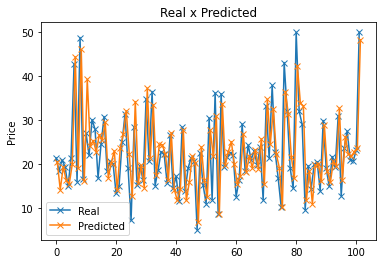

In [ ]:
plt.figure(figsize=(10000, 1000))
x = np.arange(y_test.size)
fig, ax = plt.subplots()
plt.plot(x , y_test, 'x-', label='Real')
plt.plot(x + width, y_pred, 'x-', label='Predicted')
ax.set_ylabel('Price')
ax.set_title('Real x Predicted')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()
plt.show()